In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import cmath
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%pylab inline
pylab.rcParams['figure.figsize'] = (2, 1)

Populating the interactive namespace from numpy and matplotlib


In [2]:
countByDay = pd.read_csv('data\out_countByDay.csv', index_col = 'day', header=0, parse_dates=[0]).sort_values(by = 'day')
posByDay = pd.read_csv('data\out_posByDay.csv', index_col = 'day', header=0, parse_dates=[0]).sort_values(by = 'day')
neutrByDay = pd.read_csv('data\out_neutrByDay.csv', index_col = 'day', header=0, parse_dates=[0]).sort_values(by = 'day')
negByDay = pd.read_csv('data\out_negByDay.csv', index_col = 'day', header=0, parse_dates=[0]).sort_values(by = 'day')

In [3]:
ftse = pd.read_csv('data\FTSE.csv', index_col = 'Date', header=0, parse_dates=[0]).sort_values(by = 'Date')
ftse = ftse[['Adj Close', 'Volume']]
ftse.columns = ['price', 'volume']
ftse.head()

,price,volume
Date,,
2015-02-11,6818.200195,623275800
2015-02-12,6828.100098,809863300
2015-02-13,6873.500000,734854200
2015-02-16,6857.100098,415979100
2015-02-17,6898.100098,612932700


In [4]:
# Перевод цены и объема в безразмерные (dimensionless) величины 
ftse['priceDl']  = ftse['price'].apply(lambda x: x / ftse['price'].iloc[0])
ftse['volumeDl'] = ftse['volume'].apply(lambda x: x / ftse['volume'].iloc[0])
ftse.head()

,price,volume,priceDl,volumeDl
Date,,,,
2015-02-11,6818.200195,623275800,1.000000,1.000000
2015-02-12,6828.100098,809863300,1.001452,1.299366
2015-02-13,6873.500000,734854200,1.008111,1.179019
2015-02-16,6857.100098,415979100,1.005705,0.667408
2015-02-17,6898.100098,612932700,1.011719,0.983405


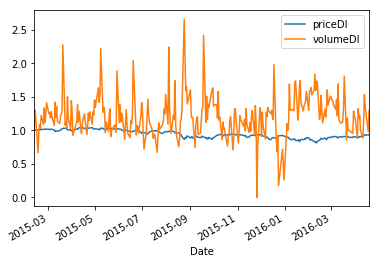

In [ ]:
ftse[['priceDl', 'volumeDl']].plot();

In [ ]:
results = pd.merge(posByDay, neutrByDay, on='day')
results = pd.merge(results, negByDay, on='day')
results.index.names = ["date"]

results.columns = ['positive', 'neutral', 'negative']
results["sentimentCoef"] = ((results["positive"] - results["negative"])/
                            (results["positive"] + results["neutral"] + results["negative"]))
results.head()

,positive,neutral,negative,sentimentCoef
date,,,,
2016-02-24,738,4624,2511,-0.225200
2016-02-25,1138,6670,3583,-0.214643
2016-02-26,952,5775,3287,-0.233174
2016-02-27,804,4578,2360,-0.200982
2016-02-28,1057,5172,2616,-0.176258


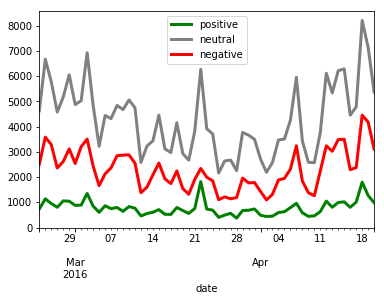

In [ ]:
results[['positive', 'neutral', 'negative']].plot(linewidth = 3, 
                                                    color=['g', 'gray', 'r']);

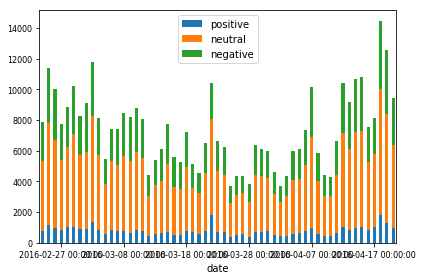

In [ ]:
results[['positive','neutral','negative']].plot.bar(stacked=True);

plt.tick_params(axis='both', which='both', labelsize=8)

plt.xticks(plt.xticks()[0][3::10], 
           plt.xticks()[1][3::10])
plt.xticks(rotation=0)
plt.tight_layout()

plt.savefig('images\stacked_bar.png')
plt.show()

In [ ]:
# allRes = pd.merge(ftse, results[['positive','neutral','negative', 'sentimentCoef']], on = 'date')
allRes = pd.merge(ftse, results, left_index=True, right_index=True)
allRes.head()

,price,volume,priceDl,volumeDl,positive,neutral,negative,sentimentCoef
2016-02-24,5867.200195,834682500,0.860520,1.339186,738,4624,2511,-0.225200
2016-02-25,6012.799805,999956900,0.881875,1.604357,1138,6670,3583,-0.214643
2016-02-26,6096.000000,858937600,0.894078,1.378102,952,5775,3287,-0.233174
2016-02-29,6097.100098,941705500,0.894239,1.510897,1045,6051,3117,-0.202879
2016-03-01,6152.899902,933626200,0.902423,1.497934,878,4872,2539,-0.200386


In [ ]:
# Центрирование безразмерных величин цены и объема
allRes['priceDlC'] = allRes['priceDl'] - allRes['priceDl'].mean()
allRes['volumeDlC'] = allRes['volumeDl'] - allRes['volumeDl'].mean()
allRes['sentimentCoefC'] = allRes['sentimentCoef'] - allRes['sentimentCoef'].mean()

allRes['complex'] = allRes['volumeDlC'] + allRes['sentimentCoefC'] * 1j
allRes.head(5)

,price,volume,priceDl,volumeDl,positive,neutral,negative,sentimentCoef,priceDlC,volumeDlC,sentimentCoefC,complex
2016-02-24,5867.200195,834682500,0.860520,1.339186,738,4624,2511,-0.225200,-0.044794,0.084173,-0.012789,(0.08417323354072792-0.012788972968866635j)
2016-02-25,6012.799805,999956900,0.881875,1.604357,1138,6670,3583,-0.214643,-0.023440,0.349344,-0.002232,(0.34934380489934647-0.0022320614828287844j)
2016-02-26,6096.000000,858937600,0.894078,1.378102,952,5775,3287,-0.233174,-0.011237,0.123089,-0.020762,(0.1230887505558278-0.020762479182484334j)
2016-02-29,6097.100098,941705500,0.894239,1.510897,1045,6051,3117,-0.202879,-0.011076,0.255884,0.009532,(0.2558837347345815+0.009532393807529793j)
2016-03-01,6152.899902,933626200,0.902423,1.497934,878,4872,2539,-0.200386,-0.002892,0.242921,0.012025,(0.2429210944395468+0.01202502403143818j)


## Нахождение коэффициента парной корреляции 

In [ ]:
def rc(y,x):
#     #Центрирование
#     yr = y.real - y.real.mean()
#     yi = y.imag - y.imag.mean()
#     xr = x.real - x.real.mean()
#     xi = x.imag - x.imag.mean()

    yr = y.real
    yi = y.imag
    xr = x.real
    xi = x.imag
    
    rc_xy = (
        ((yr + 1j*yi)*(xr + 1j*xi)).sum()
        / 
        sqrt(((yr + 1j*yi)**2).sum() * ((xr + 1j*xi)**2).sum())
        )
    return rc_xy;

In [ ]:
y = pd.DataFrame({"y":[(1+3j),(2+2j),(3+3j)],
                  "x":[(1+1j),(2+4j),(3+3j)]})
print(rc(y['y'], y['x']))
print(np.corrcoef(y['x'], y['y'])[0][1])

(-0.9701074223859091+0.10586052231081682j)
(0.15811388300841897+0.474341649025257j)


In [ ]:
y = pd.DataFrame({"y":[(1+0j),(2+2j)],
                  "x":[(0+1j),(1+2j)]})
print(rc(y['y'], y['x']))
print(np.corrcoef(y['y'], y['x'])[0][1])

(-1.0765386909793453+0.05627008447027136j)
(0.9486832980505138+0.31622776601683794j)


In [ ]:
# allRes = allRes.sort_values(by = 'date')
allRes.to_csv("data/out_allRes.csv")
#allRes

In [ ]:
print('rc volume-volume:     ' + str(rc(allRes['complex'],
                                    allRes['complex'])))

print('rc volume-price:      ' + str(rc(allRes['complex'],
                                    allRes['priceDl'])))

print('rc price-volume*1000: ' + str(rc(allRes['complex'],
                                    allRes['priceDl']*1000)))

#rc
print(rc(allRes['sentimentCoefC'], allRes['priceDlC']))
#Стандартная функция для нахождения корреляции
print(np.corrcoef(allRes['sentimentCoefC'], allRes['priceDlC'])[0][1])

#rc
print(rc(allRes['priceDlC'],allRes['complex']))
#Стандартная функция для нахождения корреляции
print(np.corrcoef(allRes['priceDlC'],allRes['complex'])[0][1])

rc volume-volume:     (1+0j)
rc volume-price:      (-0.002721963440654711-1.501590088785749e-05j)
rc price-volume*1000: (-0.0027219634406546863-1.5015900887858539e-05j)
(0.018548078910976543+0j)
0.018548078910976533
(-0.16925067162185775-0.0009336831172452041j)
(-0.165151433030158-0.0028913531808145137j)


In [ ]:
startShift = -14
endShift = 14

#correlation coef dataframe
rcdf = pd.DataFrame(columns=('shift', 'rc'))

for i in range(startShift, endShift+1):
    if (i < 0):
        row = pd.DataFrame({"shift":[i], 
                            "rc": [rc(allRes['priceDlC'].iloc[:i],
                                  allRes['complex'].shift(i).iloc[:i])],
                            "npcorr":np.corrcoef(allRes['priceDlC'].iloc[:i], 
                                                 allRes['complex'].shift(i).iloc[:i])[0][1]})
    elif (i == 0):
        row = pd.DataFrame({"shift":[i], 
                            "rc": [rc(allRes['priceDlC'],
                                  allRes['complex'])],
                            "npcorr":np.corrcoef(allRes['priceDlC'], 
                                                 allRes['complex'])[0][1]})
    else:    
        row = pd.DataFrame({"shift":[i], 
                            "rc": [rc(allRes['priceDlC'].iloc[i:],
                                  allRes['complex'].shift(i).iloc[i:])],
                            "npcorr":np.corrcoef(allRes['priceDlC'].iloc[i:], 
                                                 allRes['complex'].shift(i).iloc[i:])[0][1]})

    rcdf = rcdf.append(row, ignore_index=True, sort=False)
    
rcdf.head()

,shift,rc,npcorr
0,-14,(0.12706214562704407+0.010878113476022388j),(-0.049522143290745786-0.024486033172962298j)
1,-13,(0.13388961006743544+0.015676474562386338j),(-0.04556132022995264-0.026934397753462413j)
2,-12,(0.11663296121588679+0.02589605604794582j),(-0.07149641946302293-0.038743368764772294j)
3,-11,(-0.1720150171926959+0.01572215549122958j),(-0.3424818432765644-0.03151570408636007j)
4,-10,(0.10400613106185112+0.03444319303024696j),(-0.0354089359311147-0.04009723473682393j)


In [ ]:
rcdf['complex correlation'] = rcdf['rc'].apply(lambda x: x.real)
rcdf['standard correlation'] = rcdf['npcorr'].apply(lambda x: x.real)
rcdf[['shift','complex correlation', 'standard correlation']].plot(x = 'shift')
plt.tight_layout()
plt.savefig('images\complex and standard correlations.png')
plt.show()

In [ ]:
def linregb(y, x):
    yr = y.real
    yi = y.imag
    xr = x.real
    xi = x.imag

    b = (
        ((yr + 1j*yi)*(xr + 1j*xi)).sum()
        / 
        ((xr + 1j*xi)**2).sum()
    )

    return b

In [ ]:
train = allRes[['priceDlC','volumeDlC','sentimentCoefC','complex']].iloc[0:14]
test  = allRes[['priceDlC','volumeDlC','sentimentCoefC','complex']].iloc[15:18]

In [ ]:
#b0 + ib1, где y = 'priceDl', x = 'complex'
b = linregb(train['priceDlC'], train['complex'])
print('b = ', b)

test['lrPriceDlC'] = test['complex'] * b
test['lrPriceDlC_real'] = test['lrPriceDlC'].apply(lambda x: x.real)
test.head(5)

In [ ]:
lm = LinearRegression()
lm.fit(train[['volumeDlC', 'sentimentCoefC']], train['priceDlC'])
test['sklearnLrPriceDlC'] = lm.predict(test[['volumeDlC', 'sentimentCoefC']])

In [ ]:
complexLrRMSE = sqrt(mean_squared_error(test['priceDlC'], test['lrPriceDlC_real']))
sklearnRMSE = sqrt(mean_squared_error(test['priceDlC'], test['sklearnLrPriceDlC']))
print(complexLrRMSE)
print(sklearnRMSE)

In [ ]:
RMSE = pd.DataFrame(columns=('date','complex linear regression RMSE','standard linear regression RMSE'))
n = 7
for i in range(0, 36-n):
    train = allRes[['priceDlC','volumeDlC','sentimentCoefC','complex']].iloc[i:i+n]
    test  = allRes[['priceDlC','volumeDlC','sentimentCoefC','complex']].iloc[i+n:i+n+1]

    b = linregb(train['priceDlC'], train['complex'])
    test['lrPriceDlC'] = test['complex'] * b
    test['lrPriceDlC_real'] = test['lrPriceDlC'].apply(lambda x: x.real)

    lm = LinearRegression()
    lm.fit(train[['volumeDlC', 'sentimentCoefC']], train['priceDlC'])
    test['sklearnLrPriceDlC'] = lm.predict(test[['volumeDlC', 'sentimentCoefC']])

    row = pd.DataFrame({'complex linear regression RMSE': [sqrt(mean_squared_error(test['priceDlC'], test['lrPriceDlC_real']))],
                        'standard linear regression RMSE': [sqrt(mean_squared_error(test['priceDlC'], test['sklearnLrPriceDlC']))],
                        'date': [allRes.index[i+7]]})

    RMSE = RMSE.append(row, ignore_index=True, sort=False)  

    print(RMSE['complex linear regression RMSE'].mean(), RMSE['standard linear regression RMSE'].mean())
    
RMSE.plot(x='date', title = 'train size = 7')
plt.tight_layout()
plt.savefig('images\complex and standard linear regression RMSE.png')
plt.show()

In [ ]:
RMSE_all = pd.DataFrame(columns=('train size','complex linear regression RMSE mean','standard linear regression RMSE mean'))

for j in range(5, 16):
    RMSE = pd.DataFrame(columns=('date','complex linear regression RMSE','standard linear regression RMSE'))
    n = j
    for i in range(0, 35-n):
        train = allRes[['priceDlC','volumeDlC','sentimentCoefC','complex']].iloc[i:i+n]
        test  = allRes[['priceDlC','volumeDlC','sentimentCoefC','complex']].iloc[i+n:i+n+1]

        b = linregb(train['priceDlC'], train['complex'])
        test['lrPriceDlC'] = test['complex'] * b
        test['lrPriceDlC_real'] = test['lrPriceDlC'].apply(lambda x: x.real)

        lm = LinearRegression()
        lm.fit(train[['volumeDlC', 'sentimentCoefC']], train['priceDlC'])
        test['sklearnLrPriceDlC'] = lm.predict(test[['volumeDlC', 'sentimentCoefC']])

        row = pd.DataFrame({'complex linear regression RMSE': [sqrt(mean_squared_error(test['priceDlC'], test['lrPriceDlC_real']))],
                            'standard linear regression RMSE': [sqrt(mean_squared_error(test['priceDlC'], test['sklearnLrPriceDlC']))],
                            'date': [allRes.index[i+7]]})

        RMSE = RMSE.append(row, ignore_index=True, sort=False)  

        #print(RMSE['complex linear regression RMSE'].mean(), RMSE['standard linear regression RMSE'].mean())
    
    rowj = pd.DataFrame({'complex linear regression RMSE mean': RMSE['complex linear regression RMSE'].mean(),
                         'standard linear regression RMSE mean': RMSE['standard linear regression RMSE'].mean(),
                         'train size': [j]})
    #RMSE.plot(x='date')
    #plt.tight_layout()
    #plt.savefig('images\complex and standard linear regression RMSE.png')
    #plt.show()
    
    RMSE_all = RMSE_all.append(rowj, ignore_index=True, sort=False)  

RMSE_all.head()

In [ ]:
RMSE_all[['train size','complex linear regression RMSE mean',
          'standard linear regression RMSE mean']].plot(x='train size')
plt.tight_layout()
plt.savefig('images\complex and standard linear regression RMSE mean.png')
plt.show()

In [ ]:
startShift = -14
endShift = 14

for i in range(startShift, endShift+1):
    lrdf = pd.DataFrame(columns=('priceDlC','lrPriceDlС','complex','priceDlC_real','lrPriceDlC_real'))
    if (i < 0):
        b = linregb(allRes['priceDlC'].iloc[:i],
                    allRes['complex'].shift(i).iloc[:i])
        lrdf['priceDlC'] = allRes['priceDlC'].iloc[:i]
        lrdf['complex'] = allRes['complex'].shift(i).iloc[:i]
    
    elif (i == 0):
        b = linregb(allRes['priceDlC'],
                    allRes['complex'])
        lrdf[['priceDlC','complex']] = allRes[['priceDlC','complex']]
    
    else:    
        b = linregb(allRes['priceDlC'].iloc[i:],
                    allRes['complex'].shift(i).iloc[i:])
        lrdf['priceDlC'] = allRes['priceDlC'].iloc[i:]
        lrdf['complex'] = allRes['complex'].shift(i).iloc[i:]
    
    print('shift =', i, '  b =', b)

    lrdf = lrdf.copy(deep = True)
    lrdf['lrPriceDlС'] = lrdf['complex'] * b    

    lrdf = lrdf.append(row, ignore_index=True, sort=False)
    
    lrdf['priceDlC_real'] = lrdf['priceDlC'].apply(lambda x: x.real)
    lrdf['lrPriceDlC_real'] = lrdf['lrPriceDlС'].apply(lambda x: x.real)
    #lrdf['priceDL_imag'] = lrdf['priceDl'].apply(lambda x: x.imag)
    #lrdf['lrPriceDl_imag'] = lrdf['lrPriceDl'].apply(lambda x: x.imag)
    #lrdf[['date', 'priceDl_real', 'lrPriceDl_real', 'priceDL_imag', 'lrPriceDl_imag']].plot(x = 'date')
    #lrdf[['priceDlC', 'lrPriceDlC_real']].plot(title = 'shift = ' + str(i))

## Нормирование результатов

In [ ]:
allRes["sentimentCoefNorm"] = ((allRes["sentimentCoef"] - allRes["sentimentCoef"].min()) / 
                        (allRes["sentimentCoef"].max() - allRes["sentimentCoef"].min()))
allRes["priceNorm"]  = ((allRes["price"] - allRes["price"].min()) / 
                        (allRes["price"].max() - allRes["price"].min()))
allRes["volumeNorm"] = ((allRes["volume"] - allRes["volume"].min()) / 
                        (allRes["volume"].max() - allRes["volume"].min()))

In [ ]:
#Стандартная функция для нахождения корреляции
print(np.corrcoef(allRes['volumeNorm'], allRes['priceNorm'])[0][1])

print('rc volumeNorm-priceNorm: ' + str(rc(allRes['volumeNorm'],
                                            allRes['priceNorm'])))
# allRes[['date', 
#         'sentimentCoefNorm', 
#         'priceNorm', 
#         'volumeNorm']].plot(x='date',
#                             linewidth = 2, 
#                             color = ['r', 'steelblue', 'slateblue'])